# Collect Gridded USDM

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import rasterio.plot
from tqdm.autonotebook import tqdm

url_path = 'https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-tiff/wgs84-tiff'
cwd = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/usdm/Global'

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


The format of each gridded USDM geotiff is `USDM_YYYYMMDD.tif` ... which is then updated every week.

Let's test the first one and remember how to interact with these files

In [2]:
test = rio.open(f'{url_path}/USDM_20000104.tif')

Get some profile and meta data:

In [3]:
test.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9.0, 'width': 14358, 'height': 2142, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.025, 0.0, -179.14590760646158,
       0.0, -0.025, 71.41054810699193), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [4]:
test.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -9.0,
 'width': 14358,
 'height': 2142,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.025, 0.0, -179.14590760646158,
        0.0, -0.025, 71.41054810699193)}

In [5]:
test.shape

(2142, 14358)

In [6]:
extent = rio.plot.plotting_extent(test)
print(extent)

(-179.14590760646158, 179.80409239353847, 17.86054810699192, 71.41054810699193)


Do a basic masked plot:

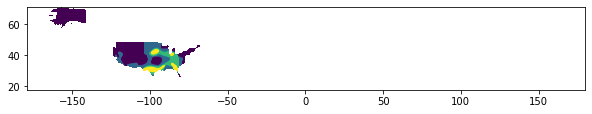

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
test_masked = test.read(1, masked=True)
ax.imshow(test_masked, extent=extent)
ax.set_aspect('equal')

Alright, let's zoom in

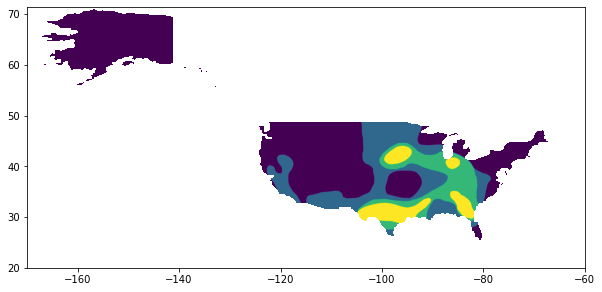

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
test_masked = test.read(1, masked=True)
ax.imshow(test_masked, extent=extent)
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

That get's us a good window. 

How well does this load with rioxarray?

In [7]:
test_rxr = rxr.open_rasterio(f'{url_path}/USDM_20000104.tif', masked=True)
test_rxr

<xarray.DataArray (band: 1, y: 2142, x: 14358)>
[30754836 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * y            (y) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [8]:
test_rxr.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -179.14590760646158 0.025 0.0 71.4105481069...

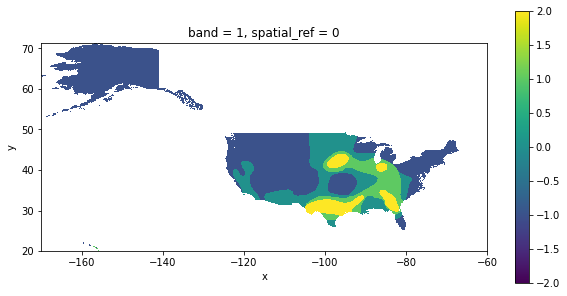

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
test_rxr.plot(ax=ax, cmap='viridis')
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

Alright, last thing I want to do is some brief quality control and check for outlier values.

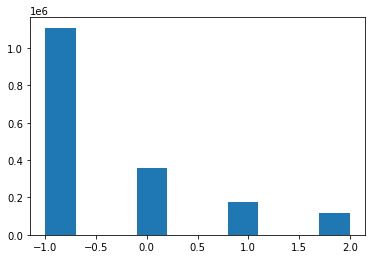

In [9]:
plt.hist(test_rxr.values.ravel());

Cool, I think we're good to start compiling more data together than just this one time frame.

## Collect Data

In [10]:
start_time = pd.to_datetime('20000104').strftime('%Y%m%d')
end_time = pd.to_datetime('20220412').strftime('%Y%m%d')

In [11]:
dates = pd.date_range(start_time, end_time, freq='7D')

for date in tqdm(dates):
    date = date.strftime('%Y%m%d')
    usdm_date_path = f'{url_path}/USDM_{date}.tif'
    
    usdm_ds = rxr.open_rasterio(usdm_date_path)
    usdm_ds.to_netcdf(f'{cwd}/USDM_{date}.nc')
    usdm_ds = None

## Combine the Data

In [12]:
test_1_path = f'{cwd}/USDM_20000104.nc'
test_2_path = f'{cwd}/USDM_20000111.nc'

In [13]:
test_1 = xr.open_dataset(test_1_path)
test_1 = test_1.rename({'band':'date', '__xarray_dataarray_variable__':'USDM', 'x':'lon', 'y':'lat'})
test_1['date'] = [pd.to_datetime('20000104')]
test_1

<xarray.Dataset>
Dimensions:      (date: 1, lon: 14358, lat: 2142)
Coordinates:
  * date         (date) datetime64[ns] 2000-01-04
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * lat          (lat) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
Data variables:
    spatial_ref  int64 ...
    USDM         (date, lat, lon) float64 ...

In [14]:
test_2 = xr.open_dataset(test_2_path)
test_2 = test_2.rename({'band':'date', '__xarray_dataarray_variable__':'USDM', 'x':'lon', 'y':'lat'})
test_2['date'] = [pd.to_datetime('20000111')]
test_2

<xarray.Dataset>
Dimensions:      (date: 1, lon: 14358, lat: 2142)
Coordinates:
  * date         (date) datetime64[ns] 2000-01-11
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * lat          (lat) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
Data variables:
    spatial_ref  int64 ...
    USDM         (date, lat, lon) float64 ...

In [15]:
test_1_2 = xr.concat([test_1, test_2], dim='date')
test_1_2

<xarray.Dataset>
Dimensions:      (date: 2, lon: 14358, lat: 2142)
Coordinates:
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * lat          (lat) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
Data variables:
    spatial_ref  (date) int64 0 0
    USDM         (date, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [16]:
test_1_2.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (date: 2, lon: 14358, lat: 2142)
Coordinates:
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * lat          (lat) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
Data variables:
    spatial_ref  (date) int64 0 0
    USDM         (date, lat, lon) float64 nan nan nan nan ... nan nan nan nan>

fig, ax = plt.subplots(figsize=(10,5))
test_1_2['USDM'].isel(date=0).plot(ax=ax, cmap='YlOrRd')
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize=(10,5))
test_1_2['USDM'].isel(date=1).plot(ax=ax, cmap='YlOrRd')
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

Alright! Those are looking good. Now instead of formatting them before the merge, can I concat them first and then format them?

In [17]:
test_3 = xr.open_mfdataset([test_1_path, test_2_path], combine='nested', concat_dim='band')
test_3 = test_3.rename({'band':'date', '__xarray_dataarray_variable__':'USDM', 'x':'lon', 'y':'lat'})
test_3['date'] = [pd.to_datetime('20000104'), pd.to_datetime('20000111')]
test_3

<xarray.Dataset>
Dimensions:      (date: 2, lon: 14358, lat: 2142)
Coordinates:
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * lat          (lat) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
Data variables:
    spatial_ref  (date) int64 0 0
    USDM         (date, lat, lon) float64 dask.array<chunksize=(1, 2142, 14358), meta=np.ndarray>

That's promising ... let's double check that the plots look good still.

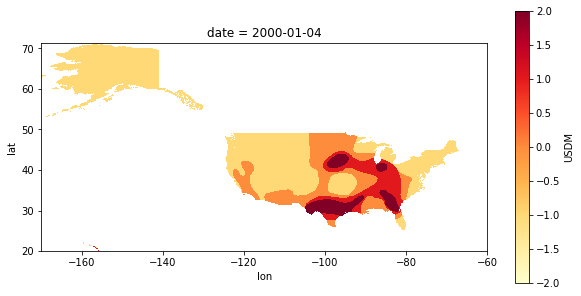

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
test_3['USDM'].isel(date=0).plot(ax=ax, cmap='YlOrRd')
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

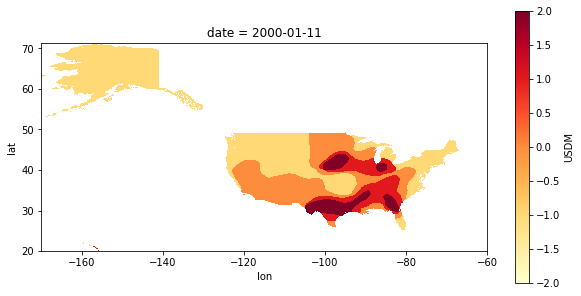

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
test_3['USDM'].isel(date=1).plot(ax=ax, cmap='YlOrRd')
ax.set_xlim(-170, -60)
ax.set_ylim(20, extent[3])
ax.set_aspect('equal')

Awesome! Let's do that for all.

In [18]:
usdm_files = [f"{cwd}/USDM_{date.strftime('%Y%m%d')}.nc" for date in dates]

In [19]:
usdm_ds = xr.open_mfdataset(usdm_files, combine='nested', concat_dim='band')

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

In [23]:
usdm_ds = usdm_ds.rename({'band':'date', '__xarray_dataarray_variable__':'USDM', 'x':'lon', 'y':'lat'})
usdm_ds['date'] = dates
usdm_ds

<xarray.Dataset>
Dimensions:      (lat: 8568, date: 1163, lon: 14358)
Coordinates:
  * lat          (lat) float64 17.87 17.87 17.87 17.87 ... 71.4 71.4 71.4 71.4
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
Data variables:
    spatial_ref  (date) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    USDM         (date, lat, lon) float64 dask.array<chunksize=(1, 8568, 14358), meta=np.ndarray>

Ayyy, that's looking fairly snazzy. Let's check in on the metadata now

In [37]:
usdm_ds['spatial_ref']

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...

Cool. I'm going to write in a bit more metadata for the overarching dataset then save it out to a netcdf.

In [48]:
usdm_ds.attrs = {
    'compilation':'a. stein, 4/18/2022',
    'description':'weekly gridded United States Drought Monitor (USDM) from 1/4/2000 to 4/18/2022',
    'source': 'https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-tiff/wgs84-tiff/',
    'notes': 'the attributes of spatial_ref contain metadata about the geography of the USDM'
}
usdm_ds['lon'].attrs = {
    'long_name': 'longitude'
}
usdm_ds['lat'].attrs = {
    'long_name': 'latitude'
}
usdm_ds['USDM'].attrs = {
    'long_name': 'United States Drought Monitor',
    'catagories': '-1:Neutral (or Wet), 0:D0 (Abnormal Dry), 1:D1 (Moderate Drought), 2:D2 (Severe Drought), 3:D3 (Extreme Drought), 4:D4 (Exceptional Drought)'
}

In [49]:
usdm_ds

<xarray.Dataset>
Dimensions:      (lat: 8568, date: 1163, lon: 14358)
Coordinates:
  * lat          (lat) float64 17.87 17.87 17.87 17.87 ... 71.4 71.4 71.4 71.4
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
    spatial_ref  int64 0
Data variables:
    USDM         (date, lat, lon) float64 dask.array<chunksize=(1, 8568, 14358), meta=np.ndarray>
Attributes:
    compilation:  a. stein, 4/18/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    notes:        the attributes of spatial_ref contain metadata about the ge...

In [50]:
usdm_ds['USDM']

<xarray.DataArray 'USDM' (date: 1163, lat: 8568, lon: 14358)>
dask.array<concatenate, shape=(1163, 8568, 14358), dtype=float64, chunksize=(1, 8568, 14358), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 17.87 17.87 17.87 17.87 ... 71.4 71.4 71.4 71.4
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
    spatial_ref  int64 0
Attributes:
    long_name:   United States Drought Monitor
    catagories:  -1:Neutral (or Wet), 0:D0 (Abnormal Dry), 1:D1 (Moderate Dro...

In [51]:
usdm_ds.to_netcdf(f'{cwd}/USDM_20000104_20220418.nc')

Alright, now to check that that saved okay ...

In [53]:
xr.open_dataset(f'{cwd}/USDM_20000104_20220418.nc')

<xarray.Dataset>
Dimensions:      (lat: 8568, date: 1163, lon: 14358)
Coordinates:
  * lat          (lat) float64 17.87 17.87 17.87 17.87 ... 71.4 71.4 71.4 71.4
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
  * lon          (lon) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
Data variables:
    USDM         (date, lat, lon) float64 ...
    spatial_ref  int64 ...
Attributes:
    compilation:  a. stein, 4/18/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    notes:        the attributes of spatial_ref contain metadata about the ge...

Woot! Now to be done with this notebook.